In [1]:
import random
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Loss, Accuracy, Precision, Recall
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.handlers import  EarlyStopping

import albumentations as A

from lunglens.data import *
from lunglens.loaders import *

Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


In [2]:
root_dir = Path('../data/prepared/covid19-ct-scans')
df = pd.read_csv(root_dir / 'metadata.csv')
df['scan_id'] = df.path.str.extract('(.+)-\d{3}\.npy')
labels = df.label.unique()
scans = df.scan_id.unique()

In [3]:
scans_train, scans_test = train_test_split(scans, test_size=0.25, random_state=42)
df_train = df[df.scan_id.isin(scans_train)]
df_test = df[df.scan_id.isin(scans_test)]
len(df_train), len(df_test)

(2459, 1061)

1630
healthy


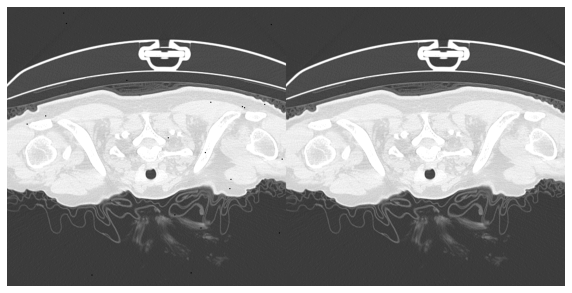

In [4]:
train_tfms = img_tfm(A.Compose([
#     A.RandomResizedCrop(img_size, img_size, scale=(.7, 1)),
#     A.Flip(),
#     A.CoarseDropout(max_holes=20, max_height=2, max_width=2),
    A.CoarseDropout(max_holes=20, max_height=2, max_width=2, p=1),
    ToColorTensor()
]))
clean_tfms = img_tfm(A.Compose([
    ToColorTensor()
]))
train_ds = SliceClassificationDataset(df_train, root_dir, labels, train_tfms, caching=True)
clean_ds = SliceClassificationDataset(df_train, root_dir, labels, clean_tfms, caching=True)
i = random.choice(range(len(train_ds)))
train_img, train_lbl = train_ds[i]
train_img = train_img[0]; clean_img = clean_ds[i][0][0]

print(i); print(labels[train_lbl.item()])

print_slice(np.concatenate([train_img, clean_img], axis=1) , figsize=(10,7))
# print_slice(clean_img, figsize=(5,5))

In [5]:
img_size = 256

train_tfms = img_tfm(A.Compose([
    A.RandomResizedCrop(img_size, img_size, scale=(.7, 1)),
    A.Flip(),
    A.CoarseDropout(max_holes=20, max_height=2, max_width=2),
    A.RandomBrightnessContrast(brightness_by_max=False),
    ToColorTensor()
]))

val_tfms = img_tfm(A.Compose([
    A.Resize(img_size, img_size),
    ToColorTensor()
]))

In [6]:
train_ds = SliceClassificationDataset(df_train, root_dir, labels, train_tfms, caching=True)
val_ds = SliceClassificationDataset(df_test, root_dir, labels, val_tfms, caching=True)

tensor(1)
tensor(0)


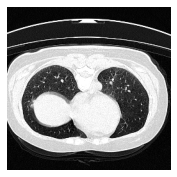

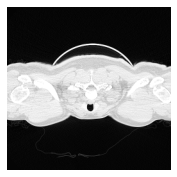

In [7]:
train_img, train_lbl = random.choice(train_ds)
val_img, val_lbl = random.choice(val_ds)

print(train_lbl)
print_slice(train_img[0], figsize=(3,3))

print(val_lbl)
print_slice(val_img[0], figsize=(3,3))

In [8]:
batch_size = 64
device = 'cuda'

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(labels))
model = model.to(device)

In [9]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=0)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [11]:
# for F1 score
precision = Precision(average=False)
recall = Recall(average=False)

metrics = {
    'loss': Loss(criterion),
    'accuracy': Accuracy(),
    'f1': (precision * recall * 2 / (precision + recall)).mean()
}

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [12]:
@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_val_metrics(engine):
    epoch = engine.state.epoch
    metrics = val_evaluator.run(val_loader).metrics
    print('Validation Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | F1: {:.4f}'
          .format(engine.state.epoch, metrics['loss'], metrics['accuracy'], metrics['f1']))

In [13]:
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(engine):
    scheduler.step()
    lr = float(optimizer.param_groups[0]['lr'])
    print("Learning rate: {}".format(lr))

In [14]:
handler = EarlyStopping(patience=10, score_function=lambda engine: engine.state.metrics['accuracy'], trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [15]:
@trainer.on(Events.EPOCH_STARTED)
def turn_on_layers(engine):
    epoch = engine.state.epoch
    if epoch == 1:
        for name, child in model.named_children():
            if name == 'fc':
                pbar.log_message(name + ' is unfrozen')
                for param in child.parameters():
                    param.requires_grad = True
            else:
                pbar.log_message(name + ' is frozen')
                for param in child.parameters():
                    param.requires_grad = False
    if epoch == 5:
        pbar.log_message("Turn on all the layers")
        for name, child in model.named_children():
            for param in child.parameters():
                param.requires_grad = True

In [16]:
import os
if not 'KAGGLE_WORKING_DIR' in os.environ:  #  If we are not on kaggle server
    from ignite.contrib.handlers.tensorboard_logger import *
    tb_logger = TensorboardLogger('logs/ResNet18-classifier-flip-aug-3-later-unfreeze')
    tb_logger.attach(trainer, log_handler=OutputHandler(tag='training', output_transform=lambda loss: {'loss': loss}),
                     event_name=Events.ITERATION_COMPLETED)

    tb_logger.attach(val_evaluator, log_handler=OutputHandler(tag='validation', metric_names=['accuracy', 'loss', 'f1'],
                     global_step_transform=global_step_from_engine(trainer)), event_name=Events.EPOCH_COMPLETED)

    tb_logger.attach(trainer, log_handler=OptimizerParamsHandler(optimizer), event_name=Events.ITERATION_STARTED)
    
    tb_logger.attach(trainer, log_handler=GradsHistHandler(model), event_name=Events.EPOCH_COMPLETED)
    tb_logger.close()

In [17]:
pbar = ProgressBar(bar_format='')
pbar.attach(trainer, output_transform=lambda x: {'loss': x})

In [18]:
trainer.run(train_loader, max_epochs=50)

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is frozen
avgpool is frozen
fc is unfrozen


Validation Results - Epoch: 1  Average Loss: 0.6367 | Accuracy: 0.6249 | F1: 0.6249
Learning rate: 0.000285


Validation Results - Epoch: 2  Average Loss: 0.6109 | Accuracy: 0.6626 | F1: 0.6617
Learning rate: 0.00027075


Validation Results - Epoch: 3  Average Loss: 0.6225 | Accuracy: 0.6654 | F1: 0.6634
Learning rate: 0.0002572125


Validation Results - Epoch: 4  Average Loss: 0.6278 | Accuracy: 0.6673 | F1: 0.6649
Learning rate: 0.000244351875
Turn on all the layers


Validation Results - Epoch: 5  Average Loss: 1.4116 | Accuracy: 0.6767 | F1: 0.6749
Learning rate: 0.00023213428124999998


Validation Results - Epoch: 6  Average Loss: 1.0907 | Accuracy: 0.6296 | F1: 0.6291
Learning rate: 0.00022052756718749997


Validation Results - Epoch: 7  Average Loss: 1.5392 | Accuracy: 0.7069 | F1: 0.7041
Learning rate: 0.00020950118882812497


Validation Results - Epoch: 8  Average Loss: 1.4741 | Accuracy: 0.6975 | F1: 0.6946
Learning rate: 0.00019902612938671872


Validation Results - Epoch: 9  Average Loss: 1.6557 | Accuracy: 0.6786 | F1: 0.6744
Learning rate: 0.00018907482291738277


Validation Results - Epoch: 10  Average Loss: 1.3762 | Accuracy: 0.7220 | F1: 0.7220
Learning rate: 0.0001796210817715136


Validation Results - Epoch: 11  Average Loss: 0.9263 | Accuracy: 0.7248 | F1: 0.7245
Learning rate: 0.00017064002768293793


Validation Results - Epoch: 12  Average Loss: 1.6950 | Accuracy: 0.6673 | F1: 0.6634
Learning rate: 0.00016210802629879103


Validation Results - Epoch: 13  Average Loss: 1.7675 | Accuracy: 0.6550 | F1: 0.6442
Learning rate: 0.00015400262498385146


Validation Results - Epoch: 14  Average Loss: 1.3458 | Accuracy: 0.7257 | F1: 0.7239
Learning rate: 0.00014630249373465888


Validation Results - Epoch: 15  Average Loss: 2.2888 | Accuracy: 0.6192 | F1: 0.6114
Learning rate: 0.00013898736904792593


Validation Results - Epoch: 16  Average Loss: 1.7607 | Accuracy: 0.6843 | F1: 0.6785
Learning rate: 0.00013203800059552963


Validation Results - Epoch: 17  Average Loss: 2.0373 | Accuracy: 0.6664 | F1: 0.6610
Learning rate: 0.00012543610056575314


Validation Results - Epoch: 18  Average Loss: 1.5029 | Accuracy: 0.6975 | F1: 0.6955
Learning rate: 0.00011916429553746547


Validation Results - Epoch: 19  Average Loss: 1.7770 | Accuracy: 0.6654 | F1: 0.6605
Learning rate: 0.0001132060807605922


Validation Results - Epoch: 20  Average Loss: 1.7047 | Accuracy: 0.6918 | F1: 0.6889
Learning rate: 0.00010754577672256258


Validation Results - Epoch: 21  Average Loss: 1.8164 | Accuracy: 0.6824 | F1: 0.6794
Learning rate: 0.00010216848788643445


Validation Results - Epoch: 22  Average Loss: 1.7820 | Accuracy: 0.6805 | F1: 0.6769
Learning rate: 9.706006349211273e-05


Validation Results - Epoch: 23  Average Loss: 2.1727 | Accuracy: 0.6861 | F1: 0.6804
Learning rate: 9.220706031750709e-05


Validation Results - Epoch: 24  Average Loss: 2.1876 | Accuracy: 0.6777 | F1: 0.6725
Learning rate: 8.759670730163173e-05


State:
	iteration: 936
	epoch: 24
	epoch_length: 39
	max_epochs: 50
	output: 0.0885855033993721
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>